# 시계열 예측 모델

Sequence (시계열) 데이터 다루기

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

**금융 데이터**를 활용한 시계열 데이터 예측

Finance DataReader를 활용하여 시계열 데이터를 로드하고 금융 데이터를 예측합니다.

## 필요한 모듈 import

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import urllib
import pandas as pd

from tensorflow.keras.layers import Dense, LSTM, GRU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Finace DataReader

[링크](https://github.com/FinanceData/FinanceDataReader)

In [ ]:
# 데이터를 받아오기 위해 finance-datareader 모듈을 설치합니다.
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.7 MB/s 


In [ ]:
import FinanceDataReader as fdr

In [ ]:
# 비트코인 시세를 가져옵니다.
data = fdr.DataReader('BTC/KRW')
data

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-05-23,3206000,3104000,3281000,3081000,21580.0,0.0329
2017-05-24,4175000,3206000,4314000,3206000,34680.0,0.3022
2017-05-25,4199000,4175000,4840000,3102000,35910.0,0.0057
2017-05-26,3227000,4199000,4200000,2900000,36650.0,-0.2315
2017-05-27,3152000,3227000,3288000,2460000,33750.0,-0.0232
...,...,...,...,...,...,...
2022-06-05,38005000,37906000,38202000,37600000,380.0,0.0026
2022-06-06,39589000,38005000,39942000,37975000,620.0,0.0417
2022-06-07,39368000,39569000,39735000,37416000,1650.0,-0.0056


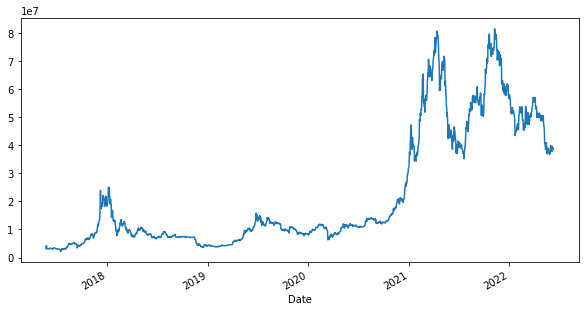

In [ ]:
data['Close'].plot(figsize=(10, 5))

In [ ]:
# 아래 컬럼의 데이터만 추출하여 최초 최대 정규화를 적용하세요.
# ['Open', 'High', 'Low', 'Close', 'Volume']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(data[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled

,Open,High,Low,Close,Volume
0,0.011237,0.011817,0.016351,0.012523,0.175837
1,0.012523,0.024706,0.017946,0.024744,0.282776
2,0.024744,0.031270,0.016619,0.025047,0.292816
3,0.025047,0.023284,0.014040,0.012788,0.298857
4,0.012788,0.011904,0.008424,0.011842,0.275184
...,...,...,...,...,...
1837,0.450152,0.447561,0.456947,0.451401,0.002776
1838,0.451401,0.469273,0.461734,0.471378,0.004735
1839,0.471125,0.466690,0.454599,0.468590,0.013143
1840,0.468590,0.464556,0.462525,0.457744,0.004490


## Train Set, Validation Set 생성

Train Set / Validation Set 를 분할 합니다.

- ~최근 500개: Train Set
- 최근 500개~: Valid Set

In [ ]:
train = df_scaled[:-500]
valid = df_scaled[-500:]

In [ ]:
train.shape, valid.shape

((1342, 5), (500, 5))

## Window Dataset Loader

자세한 Dataset 활용법은 [블로그 링크](https://teddylee777.github.io/tensorflow/dataset-batch-window)를 참고해 보시고, 연습해보세요!

- Dataset 구성에 대한 [유튜브](https://www.youtube.com/watch?v=NUMzrqxQ4zk)

In [ ]:
# 윈도우 사이즈
window_size=10
# 배치 사이즈
batch_size = 32
# 셔플 사이즈
shuffle_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

`train_set`와 `validation_set`를 만듭니다.

In [ ]:
train_set = windowed_dataset(train['Close'], 
                             window_size=window_size, 
                             batch_size=batch_size,
                             shuffle=True,
                             shuffle_buffer=shuffle_size)

validation_set = windowed_dataset(valid['Close'], 
                                  window_size=window_size,
                                  batch_size=1,
                                  shuffle=False,
                                  shuffle_buffer=shuffle_size)

In [ ]:
x, y = next(iter(train_set))

In [ ]:
x.shape, y.shape

(TensorShape([32, 10, 1]), TensorShape([32, 1]))

In [ ]:
x, y = next(iter(validation_set))

In [ ]:
x.shape, y.shape

(TensorShape([1, 10, 1]), TensorShape([1, 1]))

## 모델 정의 (Sequential)

In [ ]:
model = Sequential([
    tf.keras.layers.LSTM(16, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [ ]:
model = Sequential([
    tf.keras.layers.GRU(16, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
])

모델의 구조 요약을 확인합니다.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1152      
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


## 컴파일 (compile)

**Optimizer**의 `learning_rate`을 별도 설정합니다.

model.compile()시 우리가 튜닝한 **optimizer**와 **loss**를 활용합니다.

In [ ]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.00005),
              metrics=["mse"])

## ModelCheckpoint: 체크포인트 생성

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [ ]:
checkpoint_path = 'tmp_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

## 학습 (fit)

In [ ]:
model.fit(train_set, 
          validation_data=(validation_set), 
          epochs=100, 
          callbacks=[checkpoint],
          )

Epoch 1/100
     35/Unknown - 2s 5ms/step - loss: 9.8968e-05 - mse: 9.8968e-05
Epoch 1: val_loss did not improve from 0.00243
42/42 [==============================] - 3s 45ms/step - loss: 9.4483e-05 - mse: 9.4483e-05 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 2/100
39/42 [==========================>...] - ETA: 0s - loss: 9.6570e-05 - mse: 9.6570e-05
Epoch 2: val_loss did not improve from 0.00243
42/42 [==============================] - 1s 30ms/step - loss: 9.4477e-05 - mse: 9.4477e-05 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/100
38/42 [==========================>...] - ETA: 0s - loss: 8.3659e-05 - mse: 8.3659e-05
Epoch 3: val_loss did not improve from 0.00243
42/42 [==============================] - 2s 37ms/step - loss: 9.0192e-05 - mse: 9.0192e-05 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 4/100
37/42 [=========================>....] - ETA: 0s - loss: 1.0142e-04 - mse: 1.0142e-04
Epoch 4: val_loss did not improve from 0.00243
42/42 [==============================] - 1s 31ms/step -

## 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

In [ ]:
model.load_weights(checkpoint_path)

## 예측

In [ ]:
result = model.predict(validation_set)

In [ ]:
result.shape

(490, 1)

## 예측 데이터 시각화

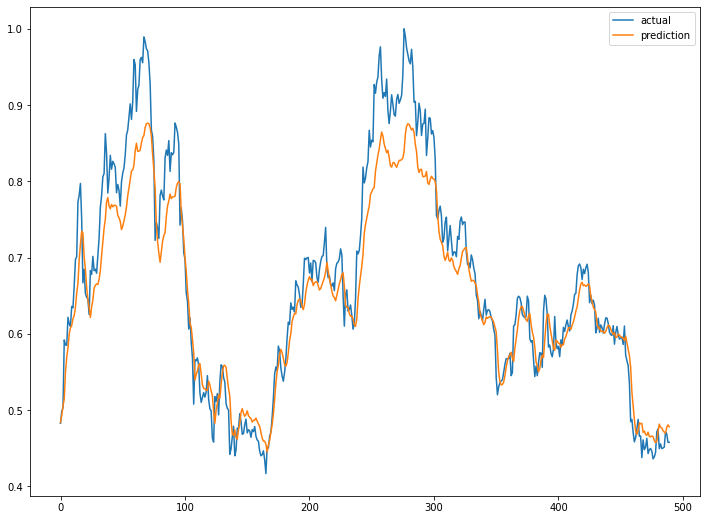

In [ ]:
import matplotlib.pyplot as plt

# 테스트의 실제값과 예측값을 시각화 하세요.
plt.figure(figsize=(12, 9))
plt.plot(valid['Close'].iloc[window_size:].values, label='actual')
plt.plot(result.reshape(-1), label='prediction')
plt.legend()
plt.show()